# Clustering Maps

Within each of the neighborhoods, there are several versions of each map. 

For instance, here are two versions of the East Village map.

<table>
<tr>
<td><img src="http://ds.civicknowledge.org/downtownsandiego.org/homeless-count/east_villiage/201601-000.png" width="400"></td>
<td><img src="http://ds.civicknowledge.org/downtownsandiego.org/homeless-count/east_villiage/201401-002.png" width="400"></td>
</tr>
</table>

Part of the process for digitizing these maps is to annotate four well-known intersections on each map; thes eintersection positions are known as ground control points. These annotations are used to transform pixel position to geographic coordinates, but they can also be used to determine the scale for a map, but looking at the four positions as a rectangle. Here is the intersection polygon for the East Village Maps.

!["East Village Intersection Region"](ev-intersection-region.png "East Village Intersection Region")

We can use the (x,y) coordinates for these rectangles to do a k-means clustering on the maps, and later use the map grouping and scale information as input to extracting features that can help identify similar maps in the future. 



In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from kneed import KneeLocator 
from shapely import wkt
import dtcv 
from dtcv.plotting import * 
from sklearn.cluster import KMeans
import statsmodels.api as sm

base_cmap = plt.get_cmap('gist_rainbow')

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


# Load in the CV Datasets

First, load in the Downtown Homelessness Computer Vision datasets. 


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Downtown Homless Computer Vision Package
`sandiegodata.org-downtown_cv-1` Last Update: 2019-09-09T17:31:58

_Files and code for analyzing san diego downtown homelessness  data with computer vision_




## Developer notes

To refresh the list of urls run

    $  bin/update_s3.sh <s3-profile>


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [gcp](data/gcp.csv)**. Ground cdontrol points
* ** [intersection_regions](data/intersection_regions.csv)**. Polygon transformations for each the intersections of each map
* ** [intersections](data/intersections.csv)**. List of intersections.

The ``intersection_regions`` dataset has URLS for each of the map images, as well as Shapely ( WKT format ) polygons composed of the intersection points. The ``gcp`` dataset has the individual, labeld intersections, but for our purposes, the polygons are easier to use. 

In [3]:
r = pkg.resource('intersection_regions')
df = r.dataframe()
display(r)


Header,Type,Description
url,string,Url to a map image
neighborhood,string,Name of the neighborhood for the maps
year,integer,Year portion of the data collection date.
intersections_id,string,A string composed of the names of the four intersections.
intersection_group,string,"A name, based on the neighbrhood, that identifies distinct intersection_id strings."
source_inv,string,"The intersection polygon, fromed from the intersection points, in WKT format, in the pixel coordinate space. This version is inverted, with the Y coordinate being subtracted from 2000, so the orientation of the Y axis is the same as the EPSG:2230 geographic coordinate space."
source,string,"Like source_inv, but the Y axis is not inverted, so the coordinates are the same as the image."
source_area,number,"Area of source shape, in square pixels"
source_shape,string,"(X,Y) shape of source polygon bounding box"
source_shape_x,integer,X value of source_shape


For the East Village neighborhood, there are two kinds of maps that are different enough ( East Village South )  that the neightborhood has two sets of intersections. The ``intersections_id`` variable identifies this case. 

## Intersection Shape Clusters 

First, let's get a view of what the space of intersection shape looks like. Here is a plot of all of the map intersection shapes, by width and height, and colored by the intersection_id, showing some clear patterns. In particular, it looks like all of the regions for a particular neighborhood all line on a line, which means that they are just scaled versions of each other, with a constant aspect ratio. And, there appear to be clusters of points. 

That gives us two interesting ways to categorize the maps: K-Means clustering, to find the clusters, and fitting them to a line.

Fitting them to a line is probably really easy, because the lines all intersect 0, and the slope will just be the ratio of Y to X. 



In [4]:

dims = pd.DataFrame({
    'map_no': df.intersection_group.astype('category').cat.codes,
    'map_name': df.intersection_group,
    'x': df.source_shape_x,
    'y': df.source_shape_y,
    'url': df.url
}).set_index('url')


The line fits look interesting,  but there are high, and very variable, y intercepts. I'd expect these all to be zero, because as the size of the region gets smaller, both the width and height should approach zero. Let's look at this again with a fit that does not use a constant, forcing the y intercept to be zero. 

columbia 574.9898135690948 -0.0919
core_columbia -144.2333026935371 0.386
cortez -102.69658544663146 0.4691
east_village_a -656.2603418673452 1.2944
east_village_b 965.7142857142826 -0.1429
gaslamp -454.4486794577109 3.5597
marina -67.7901412009981 0.6234


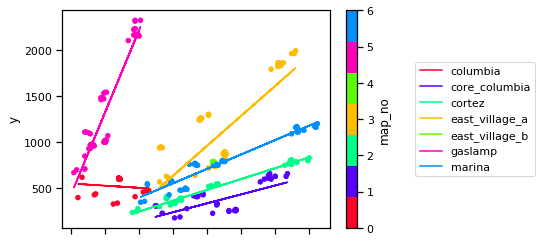

In [5]:

groups = dims.groupby(['map_name', 'map_no'])

cmap = resample_reorder_cmap(base_cmap,len(groups))

ax = dims.plot.scatter(x='x',y='y',c='map_no', colormap=cmap)

for (name, num), g in groups:
    Y = g.y.to_numpy()
    X = g.x.to_numpy()
    Xc = sm.add_constant(X)
    model = sm.OLS(Y,Xc)
    results = model.fit()
    print(name,  results.params[0], results.params[1].round(4))
   
    #aspects[name] = results.params[0]
    
    ax.plot(X, results.predict(Xc), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

Without the constant, it is more clear that the regression lines run through the middle of groups within each map that are linear within the group. For instance, the red line for Cortez, which runs through the sea-foam green points for Cortez, seems to run through two separate groups, one above the regression line, and one below. Other neighborhoods, like columbia, 

columbia 0.7446478792400848
core_columbia 0.28392988882953013
cortez 0.393112545070745
east_village_a 0.8312079620663531
east_village_b 0.6036439292291145
gaslamp 2.712220086868985
marina 0.5752354201188214


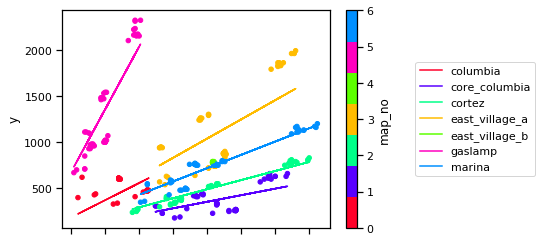

In [6]:
groups = dims.groupby(['map_name', 'map_no'])

ax = dims.plot.scatter(x='x',y='y',c='map_no', colormap=cmap)

for (name, num), g in groups:
    
    Y = g.y.to_numpy()
    X = g.x.to_numpy()

    model = sm.OLS(Y,X)
    results = model.fit()
    print(name,  results.params[0])
    
    ax.plot(X, results.predict(X), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

## K-Means Clustering

The other idea for clustering is k-means. The k-means procedure unfortunately requires knowing how many clusters you want, and we don't know. But, we do nknow it is a small number. So, we can run the process multiple times and look for the number of clusters where the matching score is sufficiently good.  The scores will ( should form a plot ) with a knee, which you can find easily with the [kneed package](https://pypi.org/project/kneed/)


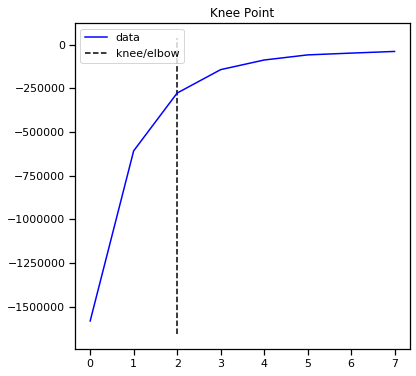

In [7]:
t = dims[dims.map_name == 'core_columbia']
X = t[['x','y']].values

scores = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    pred = kmeans.predict(X)
    scores.append(kmeans.score(X))

knee = KneeLocator(x=range(len(scores)), y=scores)

knee.plot_knee();

Here is the whole procedure to first run multiple k-means to find the optimal clusters, then run it one more time to find the clusters. 

Skipping  columbia
Skipping  east_village_b


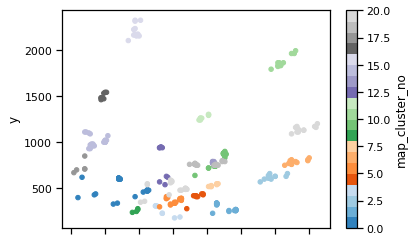

In [8]:
##
## Use KMeans to find clusters of region point shapes, to identify different kinds of maps. 
##
dims['cluster'] = None

for name, g in dims.groupby('map_name'):
    X = g[['x','y']].values
    
    # If there isn't a lot of variation in the shapes, then skip
    # the clustering. 
    m = X.mean(axis=0) # Centroid
    
    s = [np.linalg.norm(x-m) for x in X]
    
    if pd.Series(s).std() > 100:
    
        #
        # Run the KMeans multiple times and look for the knee in the
        # score vs #clusters plot

        scores = []
        n_clusters = []
        for i in range(2,10):
            kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
            pred = kmeans.predict(X)
            scores.append(kmeans.score(X))
            n_clusters.append(i)

        knee = KneeLocator(x=range(len(scores)), y=scores).knee
        clusters = n_clusters[knee]

        # Now re-run with that number of clusters. 

        kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
        pred = kmeans.predict(X)
    else:
        print('Skipping ', name)
        pred = 0
    
    dims.loc[dims.map_name==name,'cluster'] = pred
   
dims['map_cluster'] = dims.apply(lambda r: f"{r.map_name}-{r.cluster}", axis=1)
dims['map_cluster_no'] = dims.map_cluster.astype('category').cat.codes
dims.plot.scatter(x='x',y='y',c='map_cluster_no', colormap='tab20c');


That seemed to work, so let's look at the regression again, this time on the clusters, and ignoring the y-intercept. 


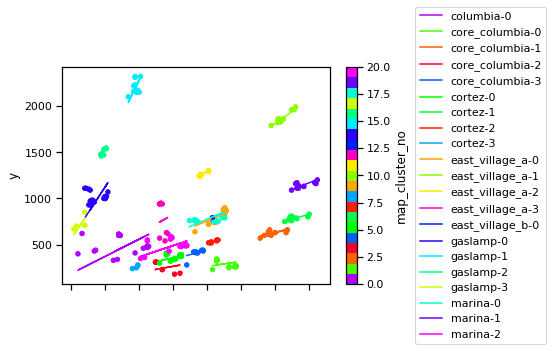

In [9]:
groups = dims.groupby(['map_cluster', 'map_cluster_no'])

cmap = resample_reorder_cmap(base_cmap,len(groups)) # rand_cmap(len(groups), type='bright')

ax = dims.plot.scatter(x='x',y='y',c='map_cluster_no', colormap=cmap)

import statsmodels.api as sm
for (name, num), g in groups:
    Y = g.y.to_numpy()
    X = g.x.to_numpy()
    
    model = sm.OLS(Y,X)
    results = model.fit()
   
    ax.plot(X, results.predict(X), label=name, color=cmap(num))
    
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5));

These clusters look very good, mostly organized around the regression lines, so we can merge the cluster values back into the main dataset and use the clusters for further analysis. 

In [10]:
df = df.merge(dims.reset_index()[['url','map_cluster']])

In [11]:
df.head().T

,0,1,2,3,4
url,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....
neighborhood,columbia,columbia,columbia,columbia,columbia
year,2015,2016,2016,2016,2016
intersections_id,"Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway","Ketner_A,Ketner_Broadway,State_A,State_Broadway"
intersection_group,columbia,columbia,columbia,columbia,columbia
source_inv,"POLYGON ((262 1743, 262.5 1123, 585.5 1118.5, ...","POLYGON ((832.5 1161, 827.5 753.5, 1541.5 750....","POLYGON ((605 1426.5, 602 1086, 1188 1086, 118...","POLYGON ((844.5 1227.5, 848.5 777.5, 1626.5 77...","POLYGON ((627 1423, 626 1097.5, 1186.5 1095.5,..."
source,"POLYGON ((262 257, 262.5 877, 585.5 881.5, 590...","POLYGON ((832.5 839, 827.5 1246.5, 1541.5 1249...","POLYGON ((605 573.5, 602 914, 1188 914, 1185 5...","POLYGON ((844.5 772.5, 848.5 1222.5, 1626.5 12...","POLYGON ((627 577, 626 902.5, 1186.5 904.5, 11..."
source_area,202299,291446,197346,352782,182724
source_shape,"(330.0, 620.0)","(720.0, 410.0)","(590.0, 340.0)","(780.0, 460.0)","(560.0, 330.0)"
source_shape_x,330,720,590,780,560


Here are the first images, and the intersections polygon, from one image from each of the clusters. 

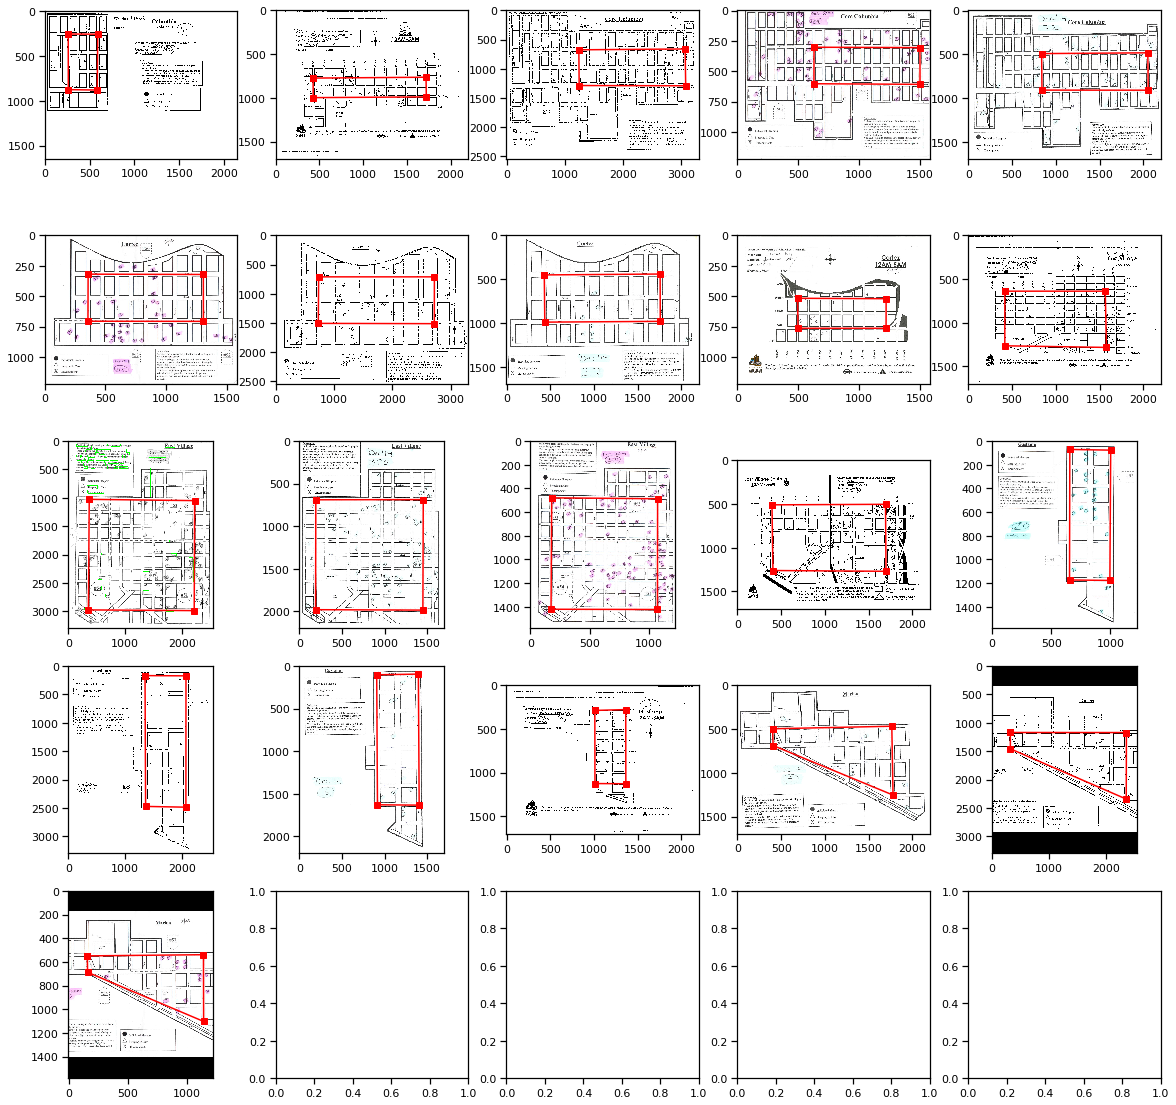

In [12]:
plot_image_and_poly(df.groupby('map_cluster').first())